In [5]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import math


In [6]:
# plane
#pc = np.load('../data/ShapeNetCore.v2.PC15k/02691156/train/1a04e3eab45ca15dd86060f189eb133.npy')

# chair
#pc = np.load('../data/ShapeNetCore.v2.PC15k/03001627/train/1a6f615e8b1b5ae4dbbc9440457e303e.npy')

# car
pc = np.load('../data/ShapeNetCore.v2.PC15k/02958343/train/1a1dcd236a1e6133860800e6696b8284.npy')

#visualize_point_cloud(pc)

/home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'multidict'

Falling back to a static output.
  warnings.warn(


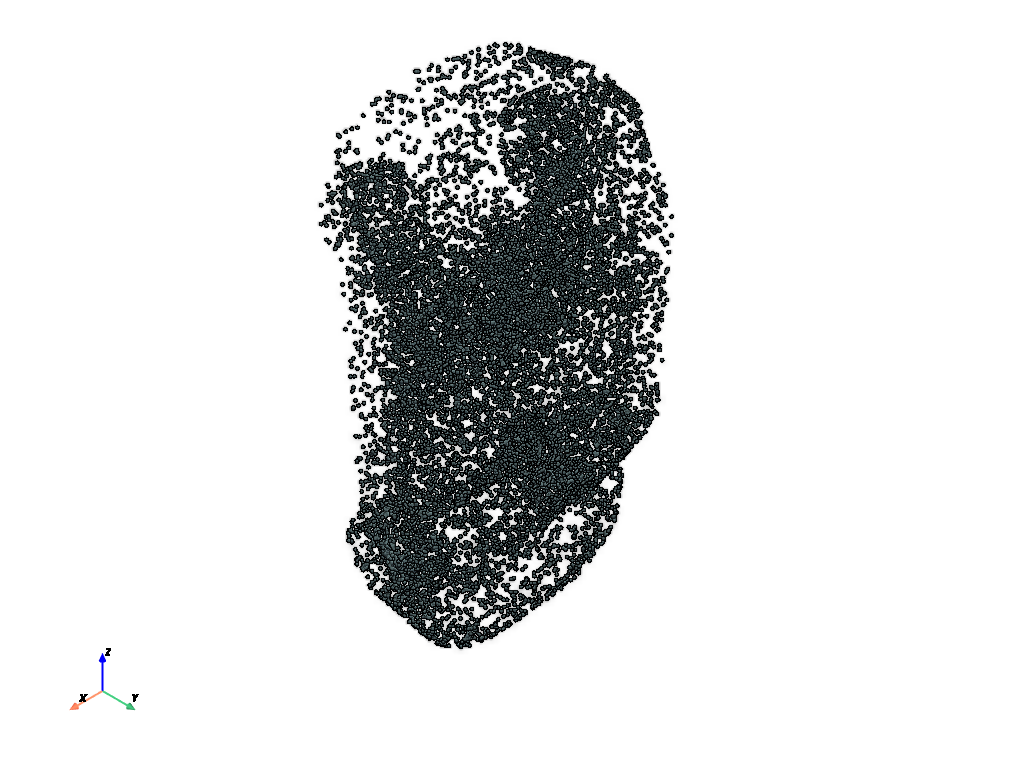

In [7]:
# visualize pc with matplotlib
def visualize_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:,0], pc[:,1], pc[:,2])
    plt.show()
    
def visualize_point_cloud_vtk(pc):
    cloud = pv.PolyData(pc)
    cloud.plot(render_points_as_spheres=True, point_size=5, eye_dome_lighting=True)

visualize_point_cloud_vtk(pc)

In [8]:
def to_spherical(coords: torch.Tensor) -> torch.Tensor:
    """
    Convert Cartesian coordinates to n-dimensional spherical coordinates.

    Args:
        coords (torch.Tensor): Tensor representing Cartesian coordinates (x_1, ... x_n).
                               Shape: (..., n)

    Returns:
        torch.Tensor: Tensor representing spherical coordinates (r, phi_1, ... phi_n-1).
                      Shape: (..., n)
    """    
    n = coords.shape[-1]
    
    # We compute the coordinates following https://en.wikipedia.org/wiki/N-sphere#Spherical_coordinates
    r = torch.norm(coords, dim=-1, keepdim=True)

    # phi_norms are the quotients in the wikipedia article above
    phi_norms = torch.norm(torch.tril(coords.flip(-1).unsqueeze(-2).expand((*coords.shape, n))), dim=-1).flip(-1)
    phi = torch.arccos(coords[..., :-2]/phi_norms[..., :-2])
    phi_final = torch.arccos(coords[..., -2:-1]/phi_norms[..., -2:-1]) + (2*math.pi - 2*torch.arccos(coords[..., -2:-1]/phi_norms[..., -2:-1]))*(coords[..., -1:] < 0)
            
    return torch.cat([r, phi, phi_final], dim=-1)

def to_cartesian(coords: torch.Tensor) -> torch.Tensor:
    """
    Convert n-dimensional spherical coordinates to Cartesian coordinates.

    Args:
        coords (torch.Tensor): Tensor representing spherical coordinates (r, phi_1, ... phi_n-1).
                               Shape: (..., n)

    Returns:
        torch.Tensor: Tensor representing Cartesian coordinates (x_1, ... x_n).
                      Shape: (..., n)
    """    
    n = coords.shape[-1]    
    r, phi = coords[..., 0:1], coords[..., 1:]
    
    phi_lower = torch.sin(torch.tril(phi.unsqueeze(-2).expand((*phi.shape, n-1))))
    phi_sin_prod = torch.prod(phi_lower + torch.triu(torch.ones((*phi.shape, n-1), device=coords.device), diagonal=1), dim=-1)
    
    x_1 = r * torch.cos(phi[..., 0:1])
    x_mid = r * torch.cos(phi[..., 1:]) * phi_sin_prod[..., :-1]
    x_n = r * phi_sin_prod[..., -1:]
    
    return torch.cat([x_1, x_mid, x_n], dim=-1)

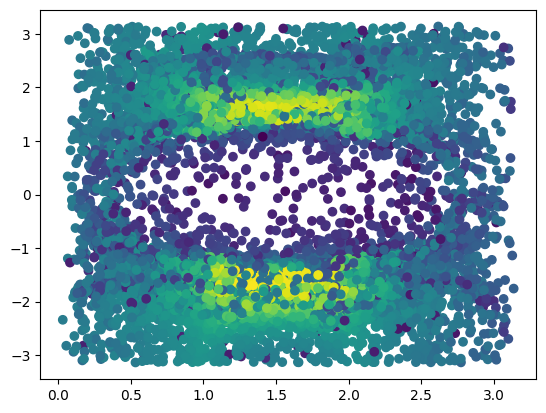

In [9]:
data = pc
# resize to grid of 512, 1024
data = torch.tensor(data)
sph_data = to_spherical(data)

#sph_data[:, 1:] = (sph_data[:, 1:] / np.pi) * 512
sph_data[:, 2] = sph_data[:, 2] - np.pi
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='mollweide')
ax.scatter(sph_data[:, 1], sph_data[:, 2], c=sph_data[:, 0], cmap='viridis')


(524288, 3)


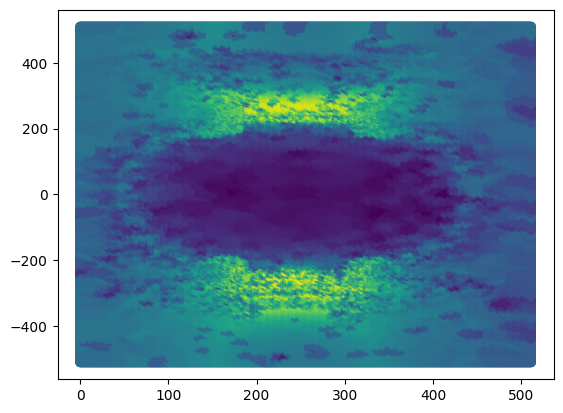

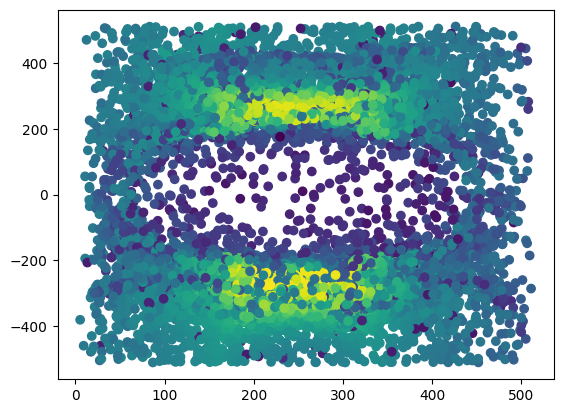

In [10]:
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from pointnet2_ops import pointnet2_utils

# create a grid of 512x1024
grid_x, grid_y = np.mgrid[0:512, -512:512]
scaled_data = sph_data.clone()
scaled_data[:, 1:] = (scaled_data[:, 1:] / np.pi) * 512

tree = cKDTree(scaled_data[:, 1:])
dist, ind = tree.query(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), k=3)
print(ind.shape)
# interpolate the data
inter_data = sph_data[:, 0][ind].mean(axis=1)
plt.scatter(grid_x, grid_y, c=inter_data, cmap='viridis')
plt.show()


plt.scatter(scaled_data[:, 1], scaled_data[:, 2], c=scaled_data[:, 0], cmap='viridis')

In [11]:
import pytorch_fre.pytorch_fre_utils as fre
import torch

In [12]:
# transform to tensor

grid = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)
grid = torch.tensor(grid, dtype=torch.float32)
print(grid.shape)
grid_cuda = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).cuda().unsqueeze(0)

torch.Size([524288, 2])


In [13]:
data_cuda = scaled_data[:, 1:].cuda().unsqueeze(0)
sph_data_cuda = scaled_data.cuda().unsqueeze(0)

In [14]:
dist, ind = fre.three_nn(grid_cuda, data_cuda)
torch.cuda.synchronize()
# ind to long
print(ind)
# interpolate the data
features_cuda = sph_data_cuda[:, :, 0].unsqueeze(0).contiguous()
print(features_cuda.shape)
weights = dist/dist.sum(dim=2, keepdim=True)
inter_data = fre.three_interpolate(features_cuda, ind, weights)

tensor([[[ 5763, 11796,   960],
         [ 5763, 11796,   960],
         [ 5763, 11796,   960],
         ...,
         [ 6211,  7870, 11593],
         [ 6211,  7870, 11593],
         [ 6211,  7870, 12746]]], device='cuda:0', dtype=torch.int32)
torch.Size([1, 1, 15000])


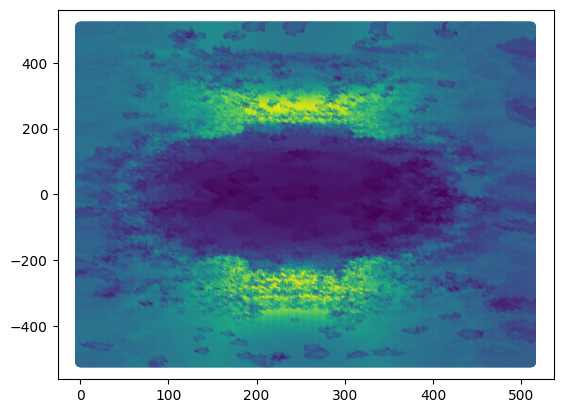

In [15]:
plt.scatter(grid_x, grid_y, c=inter_data.cpu(), cmap='viridis')
plt.show()

torch.Size([1, 1024, 512])


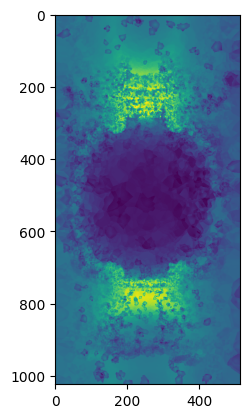

In [16]:
import torch_harmonics as th
torch.pi = math.pi

nlat = 512
nlon = 1024
batch_size = 1

sht = th.RealSHT(nlat, nlon, grid='equiangular', lmax=50, mmax=50).cuda()

reshaped_data = inter_data.reshape(batch_size, nlat, nlon).permute(0, 2, 1)
print(reshaped_data.shape)
plt.imshow(reshaped_data.cpu().numpy()[0])

coeffs = sht.forward(inter_data.reshape(batch_size, nlat, nlon))

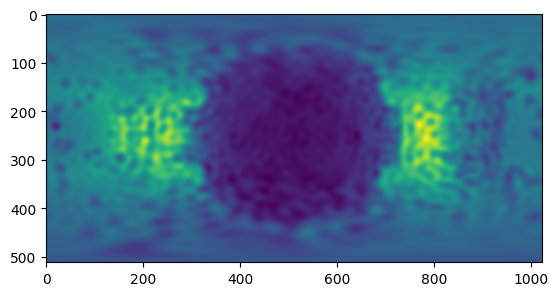

In [13]:
coeffs.shape
#plt.imshow(coeffs.cpu().real[0])
isth = th.InverseRealSHT(nlat, nlon, grid='equiangular', lmax=50, mmax=50).cuda()
reconstructed = isth.forward(coeffs)
plt.imshow(reconstructed.cpu().numpy()[0])


In [52]:
import numpy as np
import torch
from pytorch_fre import pytorch_fre_modules as fre_modules
%load_ext autoreload
%autoreload 2

loss = fre_modules.FreLoss(512, 1024, lmax=50, mmax=50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
data = np.load('../data/ShapeNetCore.v2.PC15k/02958343/train/1a1dcd236a1e6133860800e6696b8284.npy')[:4096]
data2 = np.load('../data/ShapeNetCore.v2.PC15k/02691156/train/1a04e3eab45ca15dd86060f189eb133.npy')[:4096]
data = torch.tensor(data)
data2 = torch.tensor(data2)
loss = loss.cuda()
data_cuda = data.unsqueeze(0).cuda()
data2_cuda = data2.unsqueeze(0).cuda()
data.requires_grad = True

tensor(4.1382e-05, device='cuda:0')

In [57]:
l = loss.forward(data_cuda, data2_cuda)
l

tensor(4.1382e-05, device='cuda:0')

In [ ]:
loss.backward()

In [54]:
l

tensor(0., device='cuda:0')

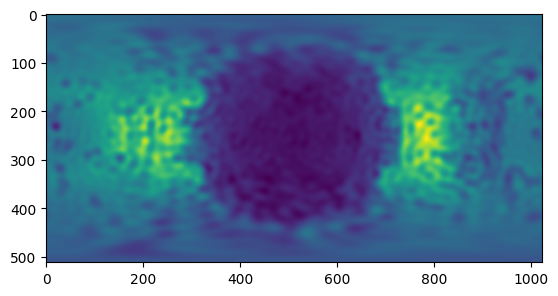

In [47]:
isht = th.InverseRealSHT(512, 1024, grid='equiangular', lmax=50, mmax=50).cuda()
recon = isht.forward(l)
plt.imshow(recon.cpu().numpy()[0])

In [20]:
np.stack([grid_x.ravel(), grid_y.ravel()], axis=1).shape
# add a third dimension to the grid with the radius being 1
grid = np.stack([np.ones(grid_x.size), grid_x.ravel(), grid_y.ravel()], axis=1)
cart = to_cartesian(torch.tensor(grid))
dist, ind = pointnet2_utils.three_nn(data.unsqueeze(0), cart.unsqueeze(0))
inter_data = data[ind[0, 1]]


tensor([[ 1.0000, -0.0000, -0.0000],
        [ 1.0000, -0.0000, -0.0000],
        [ 1.0000,  0.0000, -0.0000],
        ...,
        [-0.4717,  0.8801,  0.0546],
        [-0.4717,  0.4295,  0.7701],
        [-0.4717, -0.4159,  0.7775]], dtype=torch.float64)

In [13]:
x = np.array([[0, 1, 0], [0, 1, 1]])
y = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

y_prime = y[:, 2, np.newaxis]
print(x[:, 2], y_prime)
x[:, 2]-y_prime

[0 1] [[3]
 [6]
 [9]]


array([[-3, -2],
       [-6, -5],
       [-9, -8]])

In [14]:
def spherical_distance(p1, p2):
    sin_p1_theta = np.sin(p1[:, 1])
    sin_p2_theta = np.sin(p2[:, 1])
    cos_p1_theta = np.cos(p1[:, 1])
    cos_p2_theta = np.cos(p2[:, 1])
    cos_p1_phi_minus_p2_phi = np.cos(p1[:, 2] - p2[:, 2, np.newaxis])
    
    print(sin_p1_theta.shape, sin_p2_theta.shape, cos_p1_theta.shape, cos_p2_theta.shape, cos_p1_phi_minus_p2_phi.shape)
    out = sin_p1_theta[:, np.newaxis] * sin_p2_theta
    print(out.shape)
    print(cos_p1_phi_minus_p2_phi.shape)
    out *= cos_p1_phi_minus_p2_phi
    out += cos_p1_theta * cos_p2_theta

k = 10
sd_knn = 0.1

p1 = np.array([[0, 1, 0], [0, 1, 1]])
dist = spherical_distance(p1, spherical_pc)
ind = np.argpartition(dist, k)[:k]
dist = dist[ind]
points = pc[ind]

w_prime = np.exp(-dist**2 / 0.1)
w = w_prime / np.sum(w_prime)

print(np.sum(w*points[:, 0]))

p1[0] = np.sum(w * points[:, 0])

p1[0]

(2,) (15000,) (2,) (15000,) (15000, 2)
(2, 15000)
(15000, 2)


ValueError: operands could not be broadcast together with shapes (2,15000) (15000,2) (2,15000) 

In [15]:
visualize_point_cloud(pc)

In [23]:
norm_pc = normalize_point_cloud(pc)

In [25]:
from sklearn.neighbors import BallTree
tree = BallTree(norm_pc, metric='haversine')